In [1]:
import cv2,os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [5]:
# Data(x)
untreaded_train=np.load("results2022/untreaded_train.npy",allow_pickle=True)
# untreaded_train=np.load("results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("results2022/VPAtreaded_train.npy",allow_pickle=True)
untreaded_test=np.load("results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

untreaded_train.shape: (3000, 100, 100, 3)
VPAtreaded_train.shape: (3000, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


In [6]:
# Label(y)
y_untreaded_train = np.zeros(len(untreaded_train), dtype=np.int32)
y_VPAtreaded_train = np.ones(len(VPAtreaded_train), dtype=np.int32)

y_untreaded_test = np.zeros(len(untreaded_test), dtype=np.int32)
y_VPAtreaded_test = np.ones(len(VPAtreaded_test), dtype=np.int32)

In [7]:
# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = np.concatenate((y_untreaded_train, y_VPAtreaded_train), axis = 0), np.concatenate((y_untreaded_test, y_VPAtreaded_test), axis = 0)

# 2. Data processing

In [8]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), torch.tensor(self.y[idx], dtype=torch.long)

# trainval_data = cell_dataset(X_train, y_train)
train_data = cell_dataset(X_train, y_train)
val_data = cell_dataset(X_test, y_test)

In [9]:
batch_size = 128

# val_size = int(len(trainval_data)*0.2)
# train_size = len(trainval_data) - val_size

# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [10]:
train_data_01 = 0
train_size = len(train_data)
for i in range(train_size):
    train_data_01+=train_data[i][1].item()
print("Total number of train : ", train_size)
print("train_class_0: ", train_size-train_data_01)
print("train_class_1: ", train_data_01)

val_data_01 = 0
val_size = len(val_data)
for i in range(val_size):
    val_data_01+=val_data[i][1].item()
print("\nTotal number of val : ", val_size)
print("val_class_0: ", val_size-val_data_01)
print("val_class_1: ", val_data_01)

test_00 = y_test.tolist().count(0)
test_01 = y_test.tolist().count(1)
print("\nTotal number of test : ", len(y_test))
print("test_class_0 num : ", test_00)
print("test_class_1 num : ", test_01)

Total number of train :  6000
train_class_0:  3000
train_class_1:  3000

Total number of val :  420
val_class_0:  210
val_class_1:  210

Total number of test :  420
test_class_0 num :  210
test_class_1 num :  210


# 3. ResNet model

In [23]:
model = torch.load("model/SelfResnet9C1F_220920.pkl")

In [134]:
model = models.resnet18(pretrained=True)

model.layer3 = nn.Sequential()
model.layer4 = nn.Sequential()

model.fc = nn.Sequential(
    nn.Linear(128, 2),
#     nn.Softmax(dim=1)
)

In [103]:
# model.fc = nn.Sequential(
#     nn.Linear(128, 512),
#     nn.Dropout(p=0.5),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 2)
# )

# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

In [12]:
# model = model.cuda()
model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [13]:
image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


In [14]:
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
model.avgpool = nn.AdaptiveAvgPool2d(1)

# weight_for_0 : 1. / negative * (negative + positive)
# weight_for_1 : 1. / positive * (negative + positive)
# class_weight = {0 : weight_for_0, 1 : weight_for_1}
weights = torch.tensor([(len(untreaded_train)+len(VPAtreaded_train))/len(untreaded_train), 
                        (len(untreaded_train)+len(VPAtreaded_train))/len(VPAtreaded_train)]).cuda()
loss_function = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

In [16]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [19]:
n_epochs = 100
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.005, Accuracy: 0.999], Valid [Loss: 0.273, Accuracy: 0.929]
EPOCH: 1, Train [Loss: 0.005, Accuracy: 0.998], Valid [Loss: 0.334, Accuracy: 0.936]
EPOCH: 2, Train [Loss: 0.008, Accuracy: 0.997], Valid [Loss: 0.477, Accuracy: 0.917]
EPOCH: 3, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.303, Accuracy: 0.945]
EPOCH: 4, Train [Loss: 0.002, Accuracy: 0.999], Valid [Loss: 0.444, Accuracy: 0.943]
EPOCH: 5, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.523, Accuracy: 0.936]
EPOCH: 6, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.263, Accuracy: 0.950]
EPOCH: 7, Train [Loss: 0.003, Accuracy: 1.000], Valid [Loss: 0.321, Accuracy: 0.940]
EPOCH: 8, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.306, Accuracy: 0.940]
EPOCH: 9, Train [Loss: 0.003, Accuracy: 0.999], Valid [Loss: 0.454, Accuracy: 0.933]
EPOCH: 10, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.518, Accuracy: 0.945]
EPOCH: 11, Train [Loss: 0.003, Accuracy: 0.999], Valid [Loss: 0.

EPOCH: 96, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.458, Accuracy: 0.931]
EPOCH: 97, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.344, Accuracy: 0.938]
EPOCH: 98, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.369, Accuracy: 0.929]
EPOCH: 99, Train [Loss: 0.003, Accuracy: 0.999], Valid [Loss: 0.414, Accuracy: 0.929]


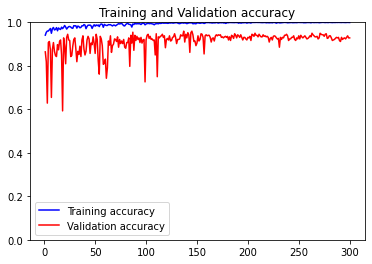

<Figure size 432x288 with 0 Axes>

In [20]:
# train processing plot
n_epochs = 300
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. Test data

In [126]:
model = torch.load("model/SelfResnet18_L2F1_200.pkl")

total_test: 420
pred_untreaded: 200 / 210, pred_VPAtreaded: 195 / 210 
accuracy_score: 0.940
precision_score: 0.951
roc_auc_score: 0.980


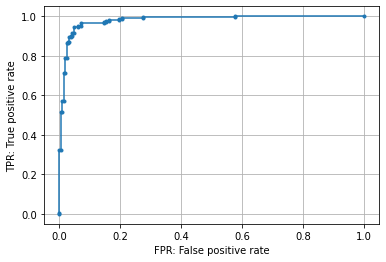

In [24]:
# Test
X = X_test
y = y_test
pred_untreaded = 0
pred_VPAtreaded = 0
y_pred = []
out_pred = []
total = X.shape[0]

model.eval()
for n in range(total):
    img = X[n]
    label = y[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    if pred==label==0:
        pred_untreaded+=1
    elif pred==label==1:
        pred_VPAtreaded+=1
    out_pred.append(output[0][1].item())
    y_pred.append(pred)

y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print("total_test: {:}" .format(total))
print("pred_untreaded: {:} / {:}, pred_VPAtreaded: {:} / {:} ".format(pred_untreaded,test_00,pred_VPAtreaded,test_01))
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y, out_pred)))

fpr, tpr, thresholds = roc_curve(y, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 99. Save model

In [22]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model,"model/SelfResnet9C1F_221108.pkl")